In [5]:
!pip install -U pandas numpy scikit-learn matplotlib seaborn
!pip install langchain_community
!pip install replicate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 3.4 MB/s eta 0:00:00


In [1]:
import os
from google.colab import userdata
from langchain_community.llms import Replicate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pickle

# --- Konfigurasi Model IBM Granite ---
try:
    api_token = userdata.get('api_token')
    os.environ["REPLICATE_API_TOKEN"] = api_token
except Exception as e:
    print("Pastiin telah menyimpan 'api_token' di Google Colab Secrets (di menu sebelah kiri, ikon kunci).")

model_id = "ibm-granite/granite-3.3-8b-instruct"
granite_llm = Replicate(
    model=model_id,
    model_kwargs={"temperature": 0.7, "max_length": 512, "top_p": 1}
)

print(f"✅ Model '{model_id}' berhasil dikonfigurasi.")

✅ Model 'ibm-granite/granite-3.3-8b-instruct' berhasil dikonfigurasi.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/world_bank_program_budget_and_all_funds_09-14-2025.csv'
df = pd.read_csv(file_path)

print("--- 5 Baris Pertama Data ---")
display(df.head())

print("\n--- Informasi Dataset ---")
df.info()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--- 5 Baris Pertama Data ---


,Work Program Group,Work Program,Unit,Fiscal Year,"Bank Budget (BB) (US$, Millions)","All Funds (US$, Millions)",Notes
0,Centrally Managed Accounts & Miscellaneous Pro...,Centrally Managed Accounts & Miscellaneous Pro...,Centrally Managed Accounts & Miscellaneous Pro...,2015,311.3,441.5,NaN
1,Client Engagement,Country Engagement,Africa,2015,167.8,355.5,NaN
2,Client Engagement,Country Engagement,East Asia & Pacific,2015,80.4,197.4,NaN
3,Client Engagement,Country Engagement,Europe & Central Asia,2015,76.6,137.8,NaN
4,Client Engagement,Country Engagement,Latin America & Caribbean,2015,86.3,134.6,NaN



--- Informasi Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739 entries, 0 to 738
Data columns (total 7 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Work Program Group                739 non-null    object 
 1   Work Program                      739 non-null    object 
 2   Unit                              739 non-null    object 
 3   Fiscal Year                       739 non-null    int64  
 4   Bank Budget (BB) (US$, Millions)  715 non-null    float64
 5   All Funds (US$, Millions)         717 non-null    float64
 6   Notes                             290 non-null    object 
dtypes: float64(2), int64(1), object(4)
memory usage: 40.5+ KB


In [6]:
column_names = ", ".join(df.columns)
prompt = f"""
As an expert data analyst, create an executive summary for a non-technical manager about a dataset containing the following columns: {column_names}.

Based on these column names, what is the primary purpose of this dataset and what kind of insights could we potentially uncover?
"""
summary = granite_llm.invoke(prompt)

print("--- Ringkasan Eksekutif dari IBM Granite ---")
print(summary)

--- Ringkasan Eksekutif dari IBM Granite ---
"Executive Summary:

This dataset provides comprehensive financial information on various work programs and units over different fiscal years. The primary purpose of this dataset is to track and analyze budget allocations, expenditures, and funding sources across different work programs and units within an organization.

Key Columns:
1. Work Program Group: Categorizes work programs based on shared characteristics or objectives.
2. Work Program: Denotes specific tasks, projects, or initiatives undertaken by the organization.
3. Unit: Represents operational divisions or departments responsible for executing work programs.
4. Fiscal Year: Indicates the time frame for budget planning, execution, and review.
5. Bank Budget (BB) (US$, Millions): Displays the allocated budget specifically for bank-related operations, measured in US dollars in millions.
6. All Funds (US$, Millions): Shows the total budget, including all sources, once again measured 

In [8]:

columns_to_drop = ['Fiscal Year', 'Notes']

df_cleaned = df.drop(columns=columns_to_drop)

print(f"Kolom yang berhasil dihapus: {columns_to_drop}")


# Mengisi nilai null pada kolom numerik dengan nilai rata-ratanya (mean)
for col in df_cleaned.select_dtypes(include=np.number).columns:
    df_cleaned[col].fillna(df_cleaned[col].mean(), inplace=True)

# Mengisi nilai null pada kolom kategorikal dengan modus (nilai paling umum)
for col in df_cleaned.select_dtypes(include='object').columns:
    df_cleaned[col].fillna(df_cleaned[col].mode()[0], inplace=True)

print("\n--- Informasi Dataset Setelah Pembersihan ---")
df_cleaned.info()

print("\n Proses pembersihan data selesai.")

Kolom yang berhasil dihapus: ['Fiscal Year', 'Notes']

--- Informasi Dataset Setelah Pembersihan ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739 entries, 0 to 738
Data columns (total 5 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Work Program Group                739 non-null    object 
 1   Work Program                      739 non-null    object 
 2   Unit                              739 non-null    object 
 3   Bank Budget (BB) (US$, Millions)  739 non-null    float64
 4   All Funds (US$, Millions)         739 non-null    float64
dtypes: float64(2), object(3)
memory usage: 29.0+ KB

 Proses pembersihan data selesai.


/tmp/ipython-input-2867916817.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned[col].fillna(df_cleaned[col].mean(), inplace=True)
/tmp/ipython-input-2867916817.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

/tmp/ipython-input-2326196439.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_cleaned, y='Work Program Group', x='All_Funds_Millions', estimator=sum, ci=None, palette='viridis')
/tmp/ipython-input-2326196439.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cleaned, y='Work Program Group', x='All_Funds_Millions', estimator=sum, ci=None, palette='viridis')


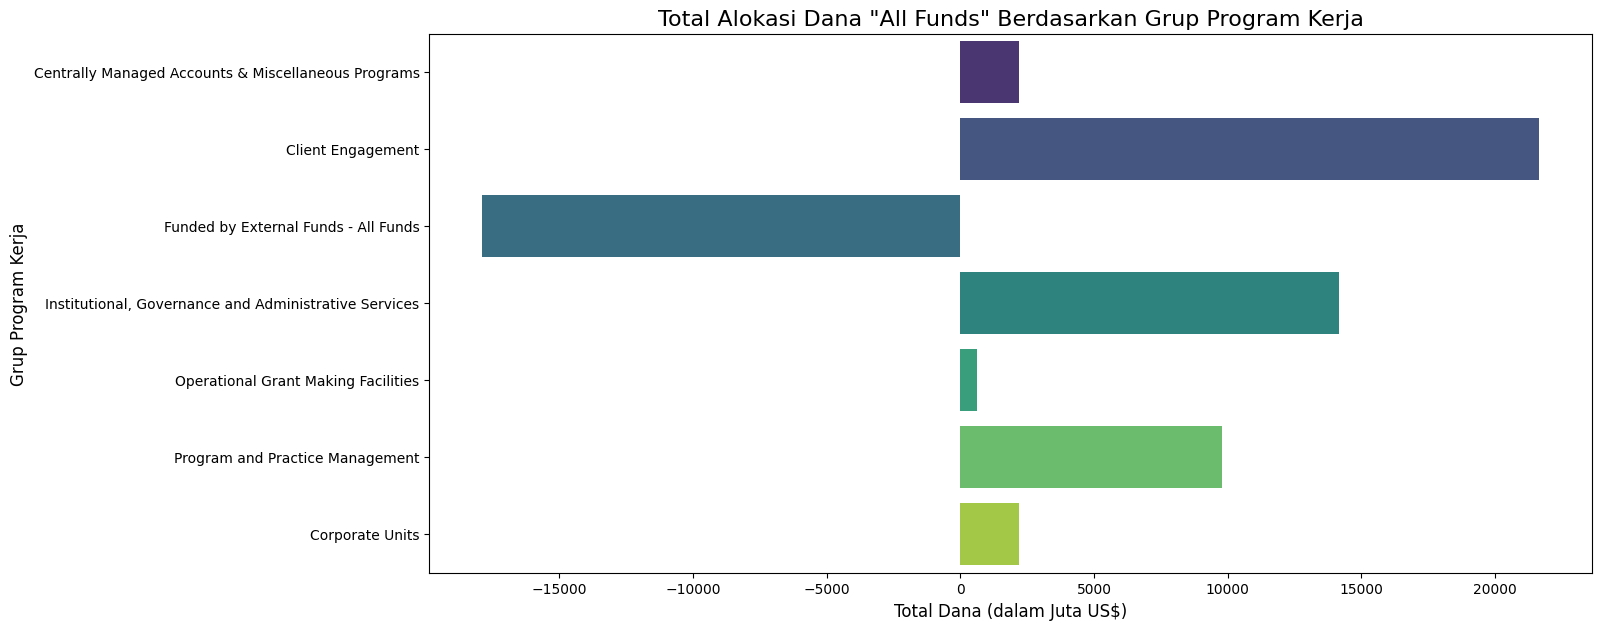

/tmp/ipython-input-2326196439.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unit_budget.values, y=unit_budget.index, palette='plasma')


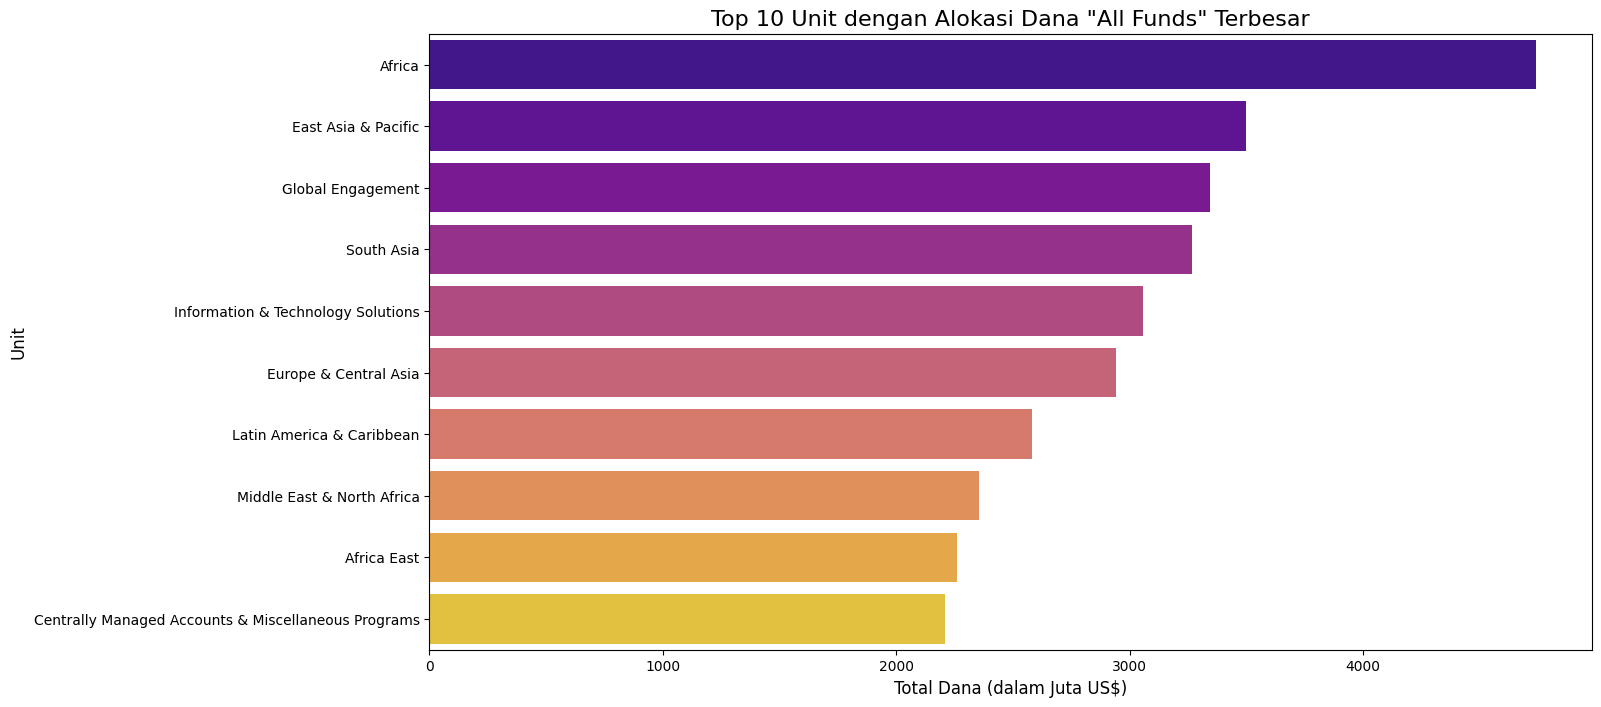

In [9]:
# Mengganti nama kolom agar lebih mudah dipanggil dalam kode
df_cleaned.rename(columns={
    'Bank Budget (BB) (US$, Millions)': 'Bank_Budget_Millions',
    'All Funds (US$, Millions)': 'All_Funds_Millions'
}, inplace=True)

# Visualisasi 1: Total Dana Berdasarkan Grup Program Kerja
plt.figure(figsize=(15, 7))
sns.barplot(data=df_cleaned, y='Work Program Group', x='All_Funds_Millions', estimator=sum, ci=None, palette='viridis')
plt.title('Total Alokasi Dana "All Funds" Berdasarkan Grup Program Kerja', fontsize=16)
plt.xlabel('Total Dana (dalam Juta US$)', fontsize=12)
plt.ylabel('Grup Program Kerja', fontsize=12)
plt.show()

# Visualisasi 2: Top 10 Unit dengan Dana Terbesar
plt.figure(figsize=(15, 8))
unit_budget = df_cleaned.groupby('Unit')['All_Funds_Millions'].sum().sort_values(ascending=False).head(10)
sns.barplot(x=unit_budget.values, y=unit_budget.index, palette='plasma')
plt.title('Top 10 Unit dengan Alokasi Dana "All Funds" Terbesar', fontsize=16)
plt.xlabel('Total Dana (dalam Juta US$)', fontsize=12)
plt.ylabel('Unit', fontsize=12)
plt.show()

In [11]:

top_group = df_cleaned.groupby('Work Program Group')['All_Funds_Millions'].sum().idxmax()

insight_prompt = f"""
Data visualization shows that the '{top_group}' work program group receives the highest total funding from the World Bank.

As a strategic analyst, provide three key potential reasons for this funding concentration and one potential risk to consider.
"""

insights = granite_llm.invoke(insight_prompt)

print(f"--- Wawasan Strategis dari IBM Granite untuk Grup '{top_group}' ---")
print(insights)

--- Wawasan Strategis dari IBM Granite untuk Grup 'Client Engagement' ---
As a strategic analyst, considering the data visualization suggesting that the 'Client Engagement' work program group receives the highest total funding from the World Bank, here are three key potential reasons for this funding concentration and one potential risk:

### Reasons for High Funding Concentration:

1. **Strategic Alignment with World Bank Goals:** 
   - The Client Engagement program likely aligns closely with the World Bank's overarching objectives, such as poverty reduction, sustainable development, and improved governance. If this group excels at facilitating partnerships and ensuring effective implementation of projects, it could be a priority for the Bank to maximize its impact and ensure funds are well-utilized.

2. **Demonstrated Effectiveness and Efficiency:**
   - The Client Engagement group may have a proven track record of successfully managing and delivering projects with high rates of comp

In [12]:

# Ini mengubah kolom seperti 'Work Program Group' menjadi beberapa kolom 0 dan 1
df_model = pd.get_dummies(df_cleaned, drop_first=True)

# saya akan memprediksi 'All_Funds_Millions'
X = df_model.drop('All_Funds_Millions', axis=1)
y = df_model['All_Funds_Millions']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model_rf.fit(X_train, y_train)

print(" Model Random Forest berhasil dilatih.")

# prediksi pada data uji
y_pred = model_rf.predict(X_test)

# Evaluasi performa model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"\n--- Hasil Evaluasi Model ---")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R2) Score: {r2:.2f}")

 Model Random Forest berhasil dilatih.

--- Hasil Evaluasi Model ---
Mean Squared Error (MSE): 628.42
R-squared (R2) Score: 0.97


In [13]:
explanation_prompt = f"""
A machine learning model achieved an R-squared score of {r2:.2f}.
Explain in simple terms to a project manager what this score means.
Focus on the model's reliability for predicting the total funding amount ('All Funds').
"""

explanation = granite_llm.invoke(explanation_prompt)

print("--- Penjelasan Performa Model dari IBM Granite ---")
print(explanation)

--- Penjelasan Performa Model dari IBM Granite ---
Dear Project Manager,

The R-squared score of 0.97 for our machine learning model indicates an exceptionally high level of reliability and accuracy in predicting the total funding amount, or 'All Funds'. 

R-squared, often represented as 'R²', is a statistical measure that represents the proportion of variance for a dependent variable that's explained by an independent variable or variables in a regression model. In simpler terms, it tells us how well the model fits the data we've used for training.

An R-squared score of 0.97 means that approximately 97% of the variation or change in the total funding amount ('All Funds') can be explained or predicted by the model using the input variables. This implies that the model captures nearly all relevant trends in the data, leaving very little unexplained variance.

In practical terms, this high score suggests that the model's predictions for total funding amounts are likely to be very close 

In [14]:
r2_score_summary = f"{r2*100:.0f}%"
top_group_summary = df_cleaned.groupby('Work Program Group')['All_Funds_Millions'].sum().idxmax()

recommendation_prompt = f"""
As a strategic consultant for the World Bank, you are presented with the following findings from a data analysis project:
1. The machine learning model can predict budget allocation with an R-squared of {r2_score_summary}. This indicates good predictability.
2. The '{top_group_summary}' work program group receives the largest portion of the total funding.

Based ONLY on these findings, provide three concrete, actionable recommendations for the World Bank's strategic management team. The recommendations should be aimed at optimizing budget allocation or exploring strategic priorities.
"""

recommendations = granite_llm.invoke(recommendation_prompt)

print("--- Rekomendasi Strategis dari IBM Granite ---")
print(recommendations)

--- Rekomendasi Strategis dari IBM Granite ---
1. **Prioritize Data-Driven Decision Making**: Given the high R-squared of 97% for the machine learning model predicting budget allocation, the World Bank should prioritize data-driven decision-making for future budget cycles. This involves:

   - **Establishing a Centralized Budget Forecasting Unit**: Create a dedicated team to oversee and refine the predictive model continuously. This unit should analyze trends, incorporate new data sources, and ensure the model's accuracy and relevance.
   - **Training and Knowledge Transfer**: Offer workshops and training sessions to strategic management team members and relevant stakeholders to boost their data literacy and understanding of the predictive model's outputs. This will enable informed discussions and consensus-building around budget allocations.
   - **Integrate Model Insights with Strategic Planning**: Ensure that the predictive model's insights are embedded within the strategic planning